In [29]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import requests
import pprint
import difflib

Loading CSV file and removing columns we dont need as they dont influence the car price.

In [30]:
#loads the data from the csv file and puts it into a pandas dataframe and assigns the header for each column
data = pd.read_csv("vehicles.csv", header = None, skiprows=[0])
column_headers = pd.read_csv("vehicles.csv", nrows=0).columns.tolist()
data.columns = column_headers
#drops columns that arent needed
data = data.drop(["id", "url", "region_url", "VIN", "size", "image_url", "description", "county", "lat", "long"], axis=1)
#drops rows with missing values in the specified column or columns
data = data.dropna(subset=["title_status", "condition"], how='all')
data = data.dropna(subset=["year", "odometer"], how='all')
data = data.dropna(subset=["year"])


Transformation/Cleaning code to replace null values for manufacturer and transmission column

In [31]:
# Curtis cell for data cleaning
#Drop all rows with no manufacturer AND no model
data = data.dropna(subset=["model", "manufacturer"], how="all")

#Find all the unique manufacturers in the 'manufacturer' column
unique_manufacturers = data["manufacturer"].dropna().unique().tolist()
if "ram" in unique_manufacturers:
    # Remove manufacturer "Ram" as it is to common in other words like Program
    unique_manufacturers.remove("ram")

# Function to fill missing manufacturers based on the model name
def check_manufacturer_in_model_name(data_row):
    # When 'manufacturer' column is null and 'model' column is not null
    if pd.isna(data_row["manufacturer"]) and pd.notna(data_row["model"]):
        for manufacturer in unique_manufacturers:
            # Change to lower-case for case-insensitive matching
            if manufacturer.lower() in data_row["model"].lower():
                return manufacturer
    return data_row["manufacturer"] # Return cleaned 'manufacturer' column

# Apply the function to update the 'manufacturer' column
data["manufacturer"] = data.apply(check_manufacturer_in_model_name, axis=1)

# Filter data to show rows where 'manufacturer' column is not null and 'model' column is not null
filtered_data = data[data["manufacturer"].notna() & data["model"].notna()]
# Create a dictionary from the filtered data mapping the 'manufacturer' of each column to a 'model'
model_to_manufacturer = filtered_data.set_index("model")["manufacturer"].to_dict()

def fill_empty_manufacturer_rows(data_row):
    # When 'manufacturer' column is null and 'model' column is not null
    if pd.isna(data_row["manufacturer"]) and pd.notna(data_row["model"]):
        # Find a close match between the dictionary keys ('model' values) and the 'model' value in the row.
        # If it matches above a certain threshold (0.7), this indicats its a strong subtring of the model value, therefore 
        # use the key's value to replace the null manufacture value
        closest_match = difflib.get_close_matches(
            data_row["model"], model_to_manufacturer.keys(), n=1, cutoff=0.7
        )
        if closest_match:
            return model_to_manufacturer[closest_match[0]]
    return data_row["manufacturer"] # Return cleaned 'manufacturer' column

# Apply the function to update the 'manufacturer' column
data["manufacturer"] = data.apply(fill_empty_manufacturer_rows, axis=1)

# Change missing values in transmission column to automatic. Based of the assumption 
# that most cars in the world today are equipped with automatic transmissions
data["transmission"] = data["transmission"].fillna(value="automatic")

Transformation/Cleaning code to replace null values of type column

In [32]:
# Curtis cell for data cleaning
# Filter data to show rows where 'type' column is not null and 'model' column is not null
filtered_data = data[data["model"].notna() & data["type"].notna()]
# Create a dictionary from the filtered data mapping the 'type' of each column to a 'model'
model_to_type = filtered_data.set_index("model")["type"].to_dict()

def fill_type(data_row):
    # When 'model' column is not null and 'type' column is null
    if data_row["model"] in model_to_type and pd.isna(data_row["type"]):
        # Use the keys in the dictionary model_to_type which are different model values, to find the key that matches
        # the model value in the row. Then use the keys value for the type column so that it is no longer null.
        return model_to_type[data_row["model"]]
    return data_row["type"]

# Apply the function to fill missing manufacturer values
data["type"] = data.apply(fill_type, axis=1)

In [33]:
# Curtis cell for data cleaning
# Find all possible unique drivetrain types and put it into a list
unique_drivetrains = data["drive"].dropna().unique().tolist()

# Check and see if any of the unique drivetrains identified in the unique drivetrain list are in the model name
pattern = '|'.join(unique_drivetrains)
data["updated_drive_train"] = data["model"].str.extract(f'({pattern})', expand=False)

# If it is present in the model name, then replace the empty 'drive' column with this drive train type
# found in the model name. For instance model: "Silverad0 1500 4wd" with and empty drive value, would have the
# drive value repplaced with 4wd as it is in the model name
data["drive"] = data["drive"].fillna(data["updated_drive_train"])
# Once done we remove the updated_drive_train column as we dont need it anymore
data.drop(columns=["updated_drive_train"], inplace=True)

Transformation/Cleaning code for posting date, and code to replace null values for car condition, fuel, title status, and odometer

In [34]:
#Cole cell for data cleaning
#The car condition that corresponds to the title status for when it is missing
title_status_mapping = {"new" : "clean", "like new" : "clean", "excellent" : "clean", "good" : "clean", "fair" : "clean", "salvage" : "salvage" }

#function to get the year of the posting
def format_dates(old_format):
    new_format = old_format.split("-")
    return int(new_format[0])

#Funciton to fill in the missing conditons based on the odometer and title_status of the car
def fill_conditions(data_row):
    vehicle_condition = data_row["condition"]
    #if the vehicle condition isnt missing
    if pd.isna(data_row["condition"]) == False:
        vehicle_condition = data_row["condition"]
    #When the vehicle condition would be considered brand new based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 500:
        vehicle_condition = "new"
    #When the vehicle condition would be considered like new based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 5000:
        vehicle_condition = "like new"
    #When the vehicle condition would be considered excellent based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 50000:
        vehicle_condition = "excellent"
    #When the vehicle condition would be considered good based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 150000:
        vehicle_condition = "good"
    #When the vehicle condition would be considered fair based on its title status and odometer
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] <= 220000:
        vehicle_condition = "fair"
    # when it doesnt fall into one of the above categories then its condition is assumed to be salvage
    else:
        vehicle_condition = "salvage"
    return vehicle_condition

data["fuel"] = data["fuel"].fillna(value="gas") #Fills the missing fuel column values with gas
#fills the missing values in the title_status column based on the title_status_mapping dictionary
data["title_status"] = data["title_status"].fillna(value=data["condition"].map(title_status_mapping))
data["posting_date"] = data["posting_date"].apply(format_dates) #formats the posting date to just be the year
#fills in missing values in the odometer column by taking the number of years the car has existed to estimate the total distance driven based on an average usage of 20000 per year
data["odometer"] = data["odometer"].fillna(value=(data["posting_date"] - data["year"]) * 20000)
data["condition"] = data.apply(fill_conditions, axis=1) #fills in missing values in the condition column based on fill_condition function

Plotting graphs for Analysis

<Figure size 640x480 with 0 Axes>

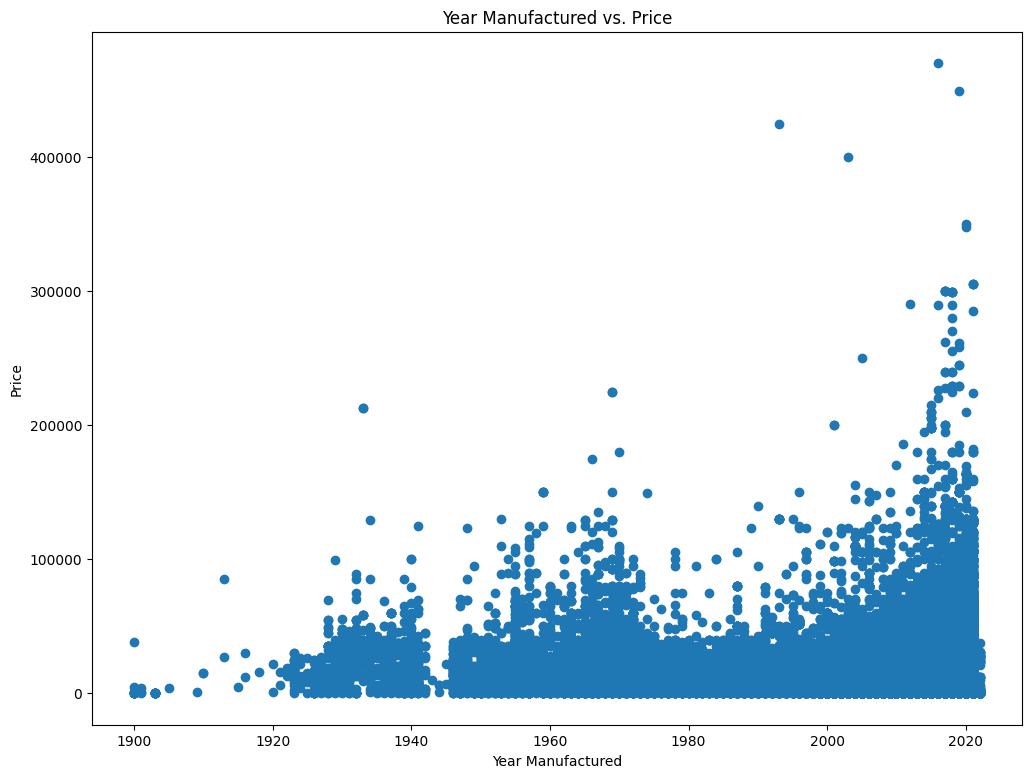

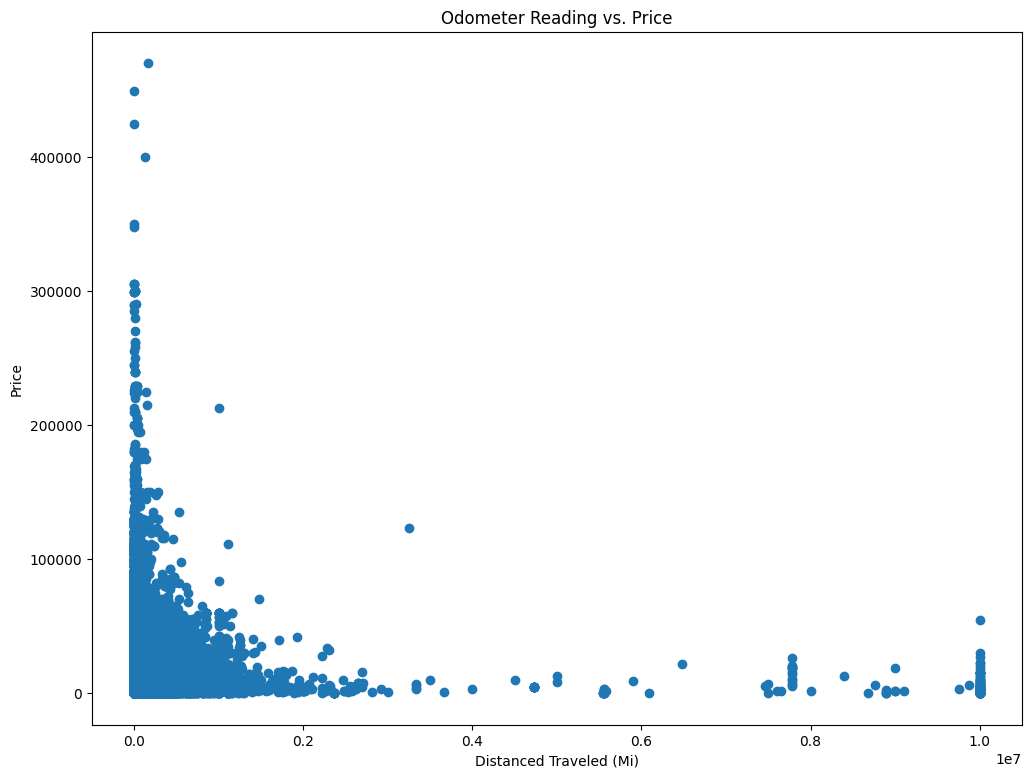

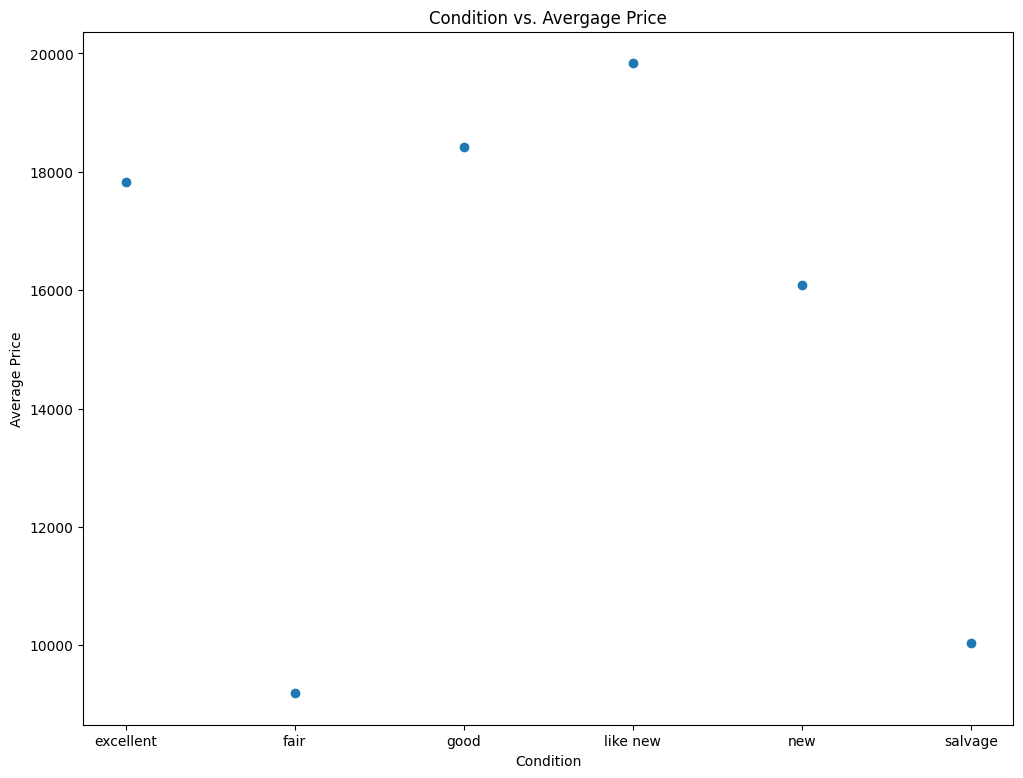

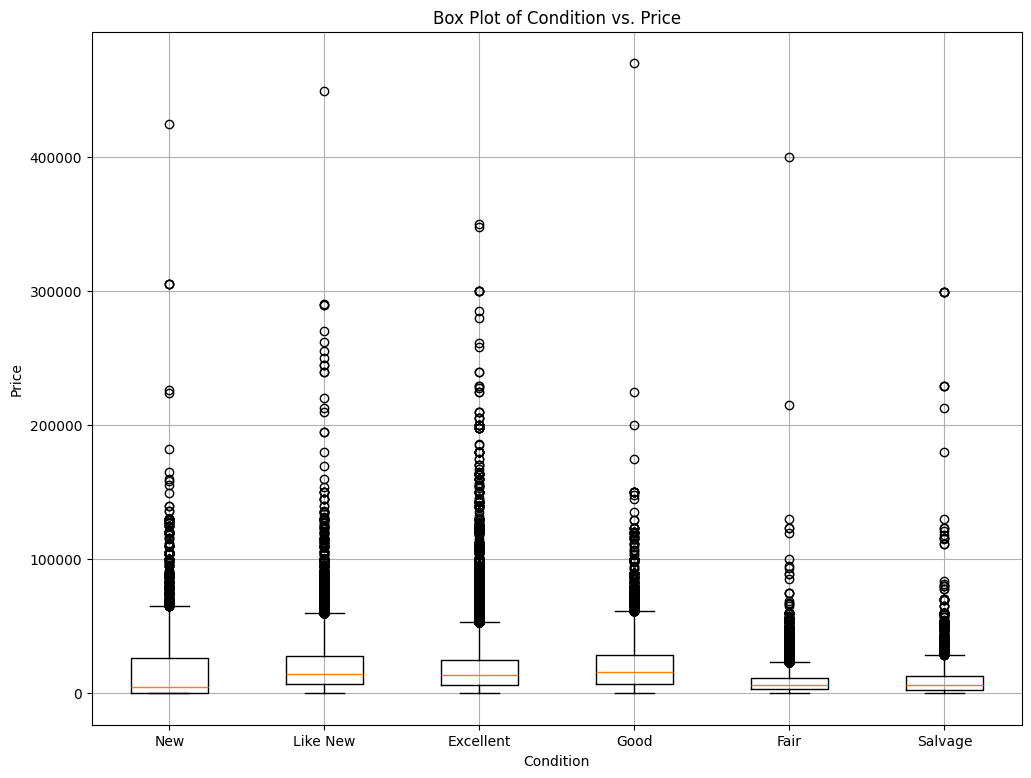

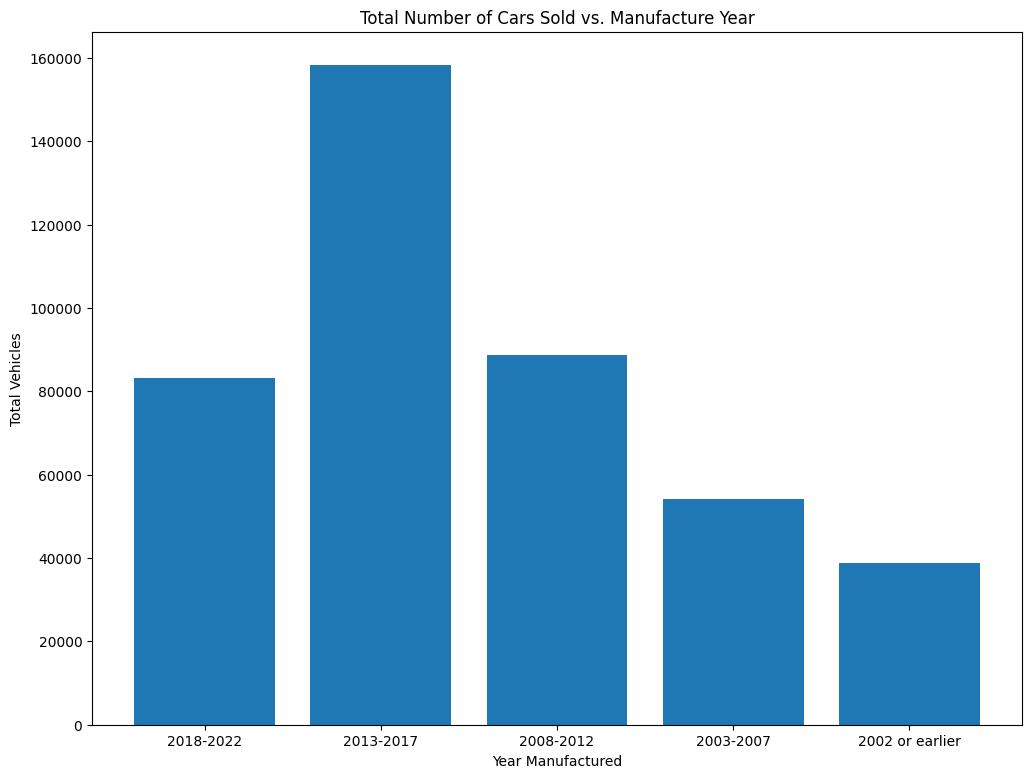

In [35]:
#code for analysis
data = data[data["price"] < 500000] #remove rows from the data where the price of the car is greater then 500000 since it is likely an outlier

#creates scatter plot of the year the car was manufactured vs the price it was sold for
plt.figure(1)
plt.figure(figsize=(12, 9))
plt.scatter(data["year"], data["price"])
plt.title("Year Manufactured vs. Price")
plt.ylabel("Price")
plt.xlabel("Year Manufactured")

#creates a scatter plot of the distance that the car has travelled vs the price it was sold for
plt.figure(2)
plt.figure(figsize=(12, 9))
plt.scatter(data["odometer"], data["price"])
plt.title("Odometer Reading vs. Price")
plt.ylabel("Price")
plt.xlabel("Distanced Traveled (Mi)")

#creates a scatter plot of the avergae price a car sold for based on its condition
plt.figure(3)
plt.figure(figsize=(12, 9))
plt.scatter(list(data.groupby("condition")["price"].groups.keys()), data.groupby("condition")["price"].mean().tolist())
plt.title("Condition vs. Avergage Price")
plt.ylabel("Average Price")
plt.xlabel("Condition")

#creates a box plot of the condition that a car is in and what it was sold for
plt.figure(4)
plt.figure(figsize=(12, 9))
#groups the data based on the condition that the car is in
new_condition = data.loc[data["condition"] == "new", ['price']]
like_new_condition = data.loc[data["condition"] == "like new", ['price']]
excellent_condition = data.loc[data["condition"] == "excellent", ['price']]
good_condition = data.loc[data["condition"] == "good", ['price']]
fair_condition = data.loc[data["condition"] == "fair", ['price']]
salvage_condition = data.loc[data["condition"] == "salvage", ['price']]
plt.boxplot([new_condition["price"], like_new_condition["price"], excellent_condition["price"], good_condition["price"], fair_condition["price"], salvage_condition["price"]])
plt.xticks([1, 2, 3, 4, 5, 6],["New", "Like New", "Excellent", "Good", "Fair", "Salvage"])

plt.title("Box Plot of Condition vs. Price")
plt.ylabel("Price")
plt.xlabel("Condition")
plt.grid(True)

#creates a bar chart for the total number of cars sold based on a 5 year manufacturer peried
plt.figure(5)
plt.figure(figsize=(12, 9))
x = np.array(["2018-2022", "2013-2017", "2008-2012", "2003-2007", "2002 or earlier"])
y = np.array([
    data[data["year"] > 2017]["year"].shape[0], 
    data[(data["year"] <= 2017) & (data["year"] > 2012)]["year"].shape[0], 
    data[(data["year"] <= 2012) & (data["year"] > 2007)]["year"].shape[0], 
    data[(data["year"] <= 2007) & (data["year"] > 2002)]["year"].shape[0],
    data[data["year"] <= 2002]["year"].shape[0]
])

plt.title("Total Number of Cars Sold vs. Manufacture Year")
plt.ylabel("Total Vehicles")
plt.xlabel("Year Manufactured")
plt.bar(x,y)

# Display the plot
plt.show()

Feature Engineering for Machine Learning

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

#Clipping Odometer max value to 270000
data['odometer'] = data['odometer'].clip(upper=270000)

#Dropping all rows with price under $500 (Most likely outlier)
data = data[data["price"] >= 500]

#Selecting Features
data_selected_features = data[["price", "year", "model", "manufacturer", "condition", "fuel", "odometer","type","region","drive"]]

#Setting target and feature datasets x = features, y = target
X = data_selected_features.drop("price", axis=1)
y = data_selected_features["price"]

#Clipping price upper limit and lower limit to lower 1st percentile and upper 99th percentile
upper_limit = np.percentile(y, 99)  
lower_limit = np.percentile(y, 1) 
y = np.clip(y, lower_limit, upper_limit)

#Setting categorical features and numerical for later encoding + scaling
categorical_features = ["model", "manufacturer", "condition", "fuel","type","region","drive"]
numerical_features = ["year", "odometer"]

#Splitting X,Y Datasets into 70/30 train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Code for Ridge Regression Model

In [ ]:
#Encoding Categorical and Numerical Columns
ridge_categorical_transformer = OneHotEncoder(handle_unknown="ignore")
ridge_numerical_transformer = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))  
])

ridge_preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", ridge_numerical_transformer, numerical_features),
        ("categorical", ridge_categorical_transformer, categorical_features),
    ]
)

#Setting the model pipeline
ridge_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", ridge_preprocessor),
        ("regressor", Ridge())
    ]
)

#Searching for best hyperparameters
ridge_param_grid = {'regressor__alpha': [0.01, 0.1, 1.0, 10, 100]}

ridge_grid_search = GridSearchCV(ridge_model_pipeline, ridge_param_grid, cv=5, scoring="neg_mean_squared_error")

ridge_grid_search.fit(X_train, y_train)

ridge_best_model = ridge_grid_search.best_estimator_

#Testing the model
ridge_y_pred = ridge_best_model.predict(X_test)

Code for XGBoost Model

In [ ]:
#Encoding Categorical and Numerical Columns
xg_boost_categorical_transformer = OneHotEncoder(handle_unknown="ignore")
xg_boost_numerical_transformer = Pipeline([
    ("scaler", StandardScaler()),
])

xg_boost_preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", xg_boost_numerical_transformer, numerical_features),
        ("categorical", xg_boost_categorical_transformer, categorical_features),
    ]
)

#Setting the model pipeline
xg_boost_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", xg_boost_preprocessor),
        ("regressor", XGBRegressor(random_state=42, objective='reg:squarederror'))
    ]
)

#Searching for best hyperparameters
xg_boost_param_grid = {
    "regressor__n_estimators": [100, 300, 500],       
    "regressor__max_depth": [3, 5, 7],               
    "regressor__learning_rate": [0.01, 0.1, 0.2],    
    "regressor__subsample": [0.8, 1.0],              
    "regressor__colsample_bytree": [0.8, 1.0]       
}

xg_boost_grid_search = GridSearchCV(xg_boost_model_pipeline, xg_boost_param_grid, cv=3, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)

xg_boost_grid_search.fit(X_train, y_train)

xg_boost_best_model = xg_boost_grid_search.best_estimator_

#Testing the model
xg_boost_y_pred = xg_boost_best_model.predict(X_test)

Code for Random Forest Model (Selected and Best Performing Model)


In [53]:
#Encoding Categorical and Numerical Columns
random_forest_categorical_transformer = OneHotEncoder(handle_unknown="ignore")
random_forest_numerical_transformer = StandardScaler()

random_forest_preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", random_forest_numerical_transformer, numerical_features),
        ("categorical", random_forest_categorical_transformer, categorical_features),
    ]
)

#Setting the model pipeline
random_forest_model_pipeline = Pipeline(
    steps=[("preprocessor", random_forest_preprocessor), ("regressor", RandomForestRegressor(random_state=42))]
)

random_forest_model_pipeline.fit(X_train, y_train)

#Testing the model
random_forest_y_pred = random_forest_model_pipeline.predict(X_test)

Code for Validation Test

In [54]:
#Ridge MSE/RMSE/MAE
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
print("Ridge MSE:", ridge_mse)

ridge_rmse = np.sqrt(ridge_mse)
print("Ridge RMSE:", ridge_rmse)

ridge_mae = mean_absolute_error(y_test, ridge_y_pred)
print("Ridge MAE:", ridge_mae)
print("")

#XGBoost MSE/RMSE/MAE
xg_boost_mse = mean_squared_error(y_test, xg_boost_y_pred)
print("XGBoost MSE:", xg_boost_mse)

xg_boost_rmse = np.sqrt(xg_boost_mse)
print("XGBoost RMSE:", xg_boost_rmse)

xg_boost_mae = mean_absolute_error(y_test, xg_boost_y_pred)
print("XGBoost MAE:", xg_boost_mae)
print("")

#Random Forest MSE/RMSE/MAE
random_forest_mse = mean_squared_error(y_test, random_forest_y_pred)
print("Random Forest MSE:", random_forest_mse)

random_forest_rmse = np.sqrt(random_forest_mse)
print("Random Forest RMSE:", random_forest_rmse)

random_forest_mae = mean_absolute_error(y_test, random_forest_y_pred)
print("Random Forest MAE:", random_forest_mae)
print("")

Ridge MSE: 40123951.8805701
Ridge RMSE: 6334.346997171066
Ridge MAE: 3717.9963211635513

XGBoost MSE: 32370174.20246871
XGBoost RMSE: 5689.479255825502
XGBoost MAE: 3548.522783632445

Random Forest MSE: 22359907.315697238
Random Forest RMSE: 4728.6263666838
Random Forest MAE: 2150.4707047941424



Based on validation tests, the random forest model gave us the best results and will be the model used going forward.

Testing the Random Forest Model with actual car data on used car sites to Simulate user usage

In [93]:
#Test Data for Toyota Corolla
corolla_test_data = pd.DataFrame({
    "year": ["2017"],
    "model": ["corolla"], 
    "manufacturer": ["toyota"],
    "condition": ["good"],
    "fuel": ["gas"], 
    "odometer": [60000],
    "type": ["sedan"], 
    "region": ["los angeles"],
    "drive": ["fwd"],
})

corolla_predicted_price = random_forest_model_pipeline.predict(corolla_test_data)
print(corolla_predicted_price)

[15241.43]


In [94]:
#Test Data for Chevrolet Silverado
silverado_test_data = pd.DataFrame({
    "year": ["2020"],
    "model": ["silverado 1500"], 
    "manufacturer": ["chevrolet"],
    "condition": ["good"],
    "fuel": ["diesel"], 
    "odometer": [50000],
    "type": ["truck"], 
    "region": ["los angeles"],
    "drive": ["awd"],
})

silverado_predicted_price = random_forest_model_pipeline.predict(silverado_test_data)
print(silverado_predicted_price)

[43809.95]
